<a href="https://colab.research.google.com/github/shanikagalaudage/tutorials/blob/main/some_fun_with_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting started**
Let's install some stuff first for plotting and parameter estimation

In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bilby

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 4.3 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 661 kB/s 
  Created wheel for bilby: filename=bilby-1.1.5-py3-none-any.whl size=2250290 sha256=837e0bd8fc46d22979cc1c0b84d14806bc049babb1bb1f226c71c1b5953b1ce3
  Stored in directory: /root/.cache/pip/wheels/d9/4b/7f/9b616adfbe3e613bf0abe6c320a9b5bc988e411201c12eca19
Successfully built bilby


In [37]:
# import stuff
import numpy as np
import pandas as pd
import bilby
from bilby.core.prior import PriorDict, Uniform, LogUniform, PowerLaw, Interped
import matplotlib.pyplot as plt
from matplotlib import rcParams


# formatting for figures
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Computer Modern"
rcParams["font.family"] = "Serif"

rcParams["legend.fontsize"]=14
rcParams["legend.framealpha"]=0.5
rcParams["legend.frameon"]=True
rcParams["legend.edgecolor"]="white"
rcParams["axes.labelsize"]=14
rcParams["axes.grid"] = True
rcParams["grid.color"] = "black"
rcParams["grid.linewidth"] = 1
rcParams["grid.linestyle"] = "--"
rcParams["grid.alpha"] = 0.3

rcParams["xtick.labelsize"]=16
rcParams["ytick.labelsize"]=16
rcParams["legend.fontsize"]=16
rcParams["axes.labelsize"]=18
rcParams["axes.titlesize"]=18

## **Time to talk about priors**

A prior is really our 'best guess' of the range and shape of the distribution of a given parameter.

For example, if we believe that black holes masses range from 3-100 solar masses and any mass is equally likely, then your prior would be a uniform distribution from 3-100. Let's draw some samples and calculate some priors.



In [ ]:
m_min = 3
m_max = 100

def uniform_prior_draw_sample(m_min, m_max, n_samples):
  return np.random.uniform(m_min, m_max, n_samples)

def uniform_prior_prob(val, m_min, m_max):
  prob = ((val >= m_min) & (val <= m_max)) / (m_max - m_min)
  return prob

Text(0, 0.5, 'probability')

findfont: Font family ['Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Serif'] not found. Falling back to DejaVu Sans.


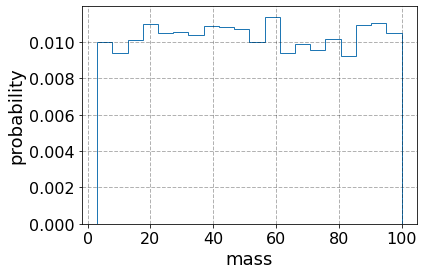

In [ ]:
n_samples = 5000
masses = uniform_prior_draw_sample(m_min, m_max, n_samples)

plt.figure(figsize=(6,4))
plt.hist(masses, bins=20, histtype="step", density=1)
plt.xlabel("mass")
plt.ylabel("probability")


In [ ]:
print(uniform_prior_prob(2, m_min, m_max)) # outside our prior range, so should return prob=0
print(uniform_prior_prob(37, m_min, m_max))

0.0
0.010309278350515464


The prior functions we wrote + more prior distributions can be found in [Bilby](https://lscsoft.docs.ligo.org/bilby). 

In [ ]:
priors = bilby.core.prior.Uniform(name="mass_1", minimum=3, maximum=100, unit="$M_{\\odot}$")
samples = priors.sample(5000)
probs = priors.prob(samples)

Text(0.5, 1.0, 'Mass samples drawn using bilby prior')

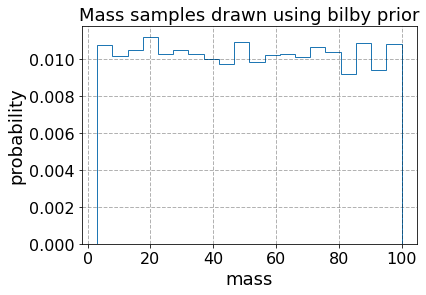

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(samples, bins=20, histtype="step", density=1)
plt.xlabel("mass")
plt.ylabel("probability")
plt.title("Mass samples drawn using bilby prior")

But uniform is mass is not really realistic... How do we know? Well the distribution of masses we see with LIGO-Virgo-KAGRA are not uniform when we look at the population.

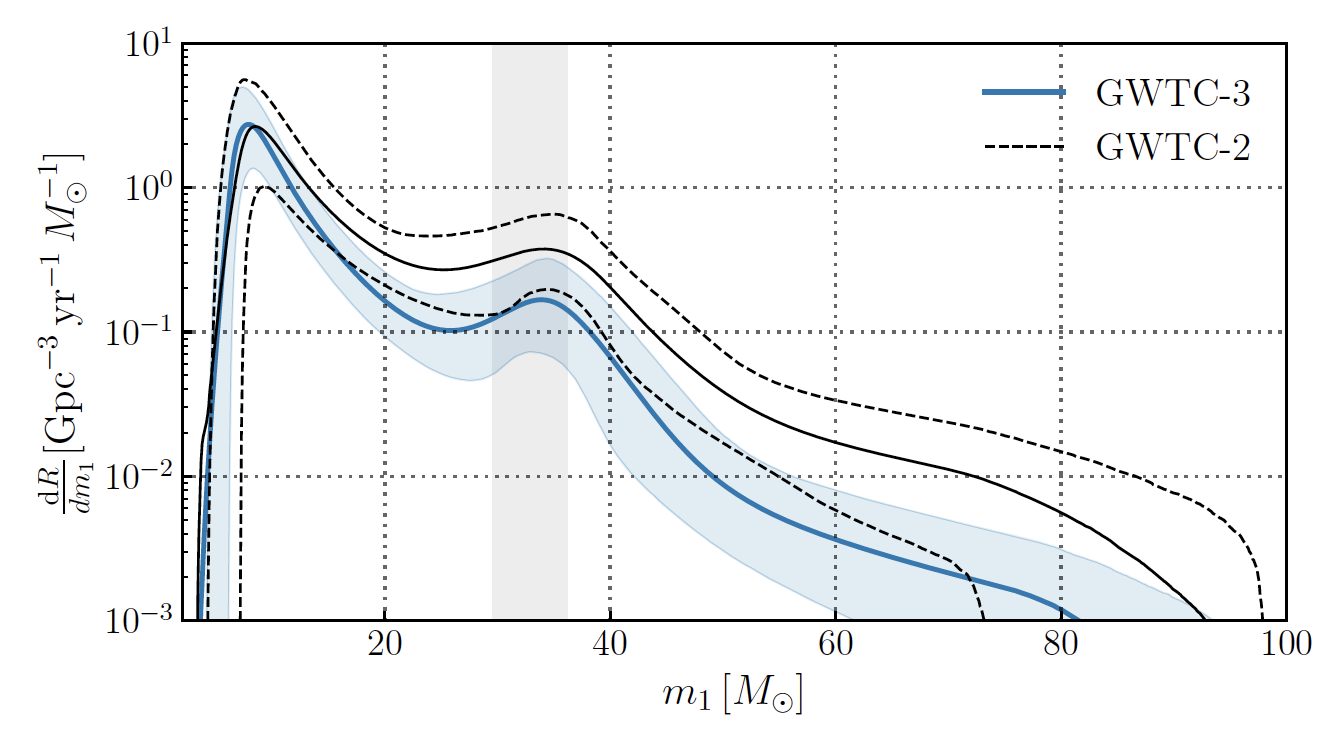

Lucky for us we can reweight our event posteriors by different priors! Let's try this for a simulated event.

In [24]:
# Load posterior file
posteriors = pd.read_pickle("./posteriors_gwtc1.pkl")

EVENT_IDX = {
    'GW150914':0,
    'GW151012':1,
    'GW151226':2,
    'GW170104':3,
    'GW170608':4,
    'GW170729':5,
    'GW170809':6,
    'GW170814':7,
    'GW170818':8,
    'GW170823':9,
}

In [55]:
def downsample_posteriors(posteriors, max_samples=5000):
    for posterior in posteriors:
        max_samples = min(len(posterior), max_samples)
    data = {key: [] for key in posteriors[0]}
    samples_per_posterior = max_samples
    for posterior in posteriors:
        temp = posterior.sample(samples_per_posterior)
        for key in data:
            data[key].append(temp[key])
    for key in data:
        data[key] = np.array(data[key])
    return data, samples_per_posterior

def mass_1_prior_reweighting(samples_per_posterior, n_posteriors, original_samples, new_prior, old_prior):
    weights = np.zeros((n_posteriors, samples_per_posterior))
    event_weights = np.zeros(n_posteriors)
    weights = (new_prior['mass_1'].prob(data['mass_1']))/(old_prior['mass_1'].prob(data['mass_1']))
    weights = (weights.T / np.sum(weights, axis=-1)).T
    new_idxs = np.empty_like(weights, dtype=int)
    for ii in range(n_posteriors):
        new_idxs[ii] = np.asarray(
            np.random.choice(
                range(samples_per_posterior),
                size=samples_per_posterior,
                replace=True,
                p=weights[ii],
                )
            )
    new_samples = {
        key: np.vstack(
            [data[key][ii, new_idxs[ii]] for ii in range(n_posteriors)]
        )
        for key in data
    }
    event_weights = list(event_weights)
    weight_string = " ".join([f"{float(weight):.1f}" for weight in event_weights])
    return new_samples, weights

In [56]:
old_prior = PriorDict()
old_prior["mass_1"] = Uniform(minimum=3, maximum=100, unit="$M_{\\odot}$")
new_prior = PriorDict()
new_prior["mass_1"] = PowerLaw(name="mass_1", alpha=-3.5, minimum=3, maximum=100, unit="$M_{\\odot}$")


n_posteriors = len(posteriors)
original_samples, samples_per_posterior = downsample_posteriors(posteriors, max_samples=5000)


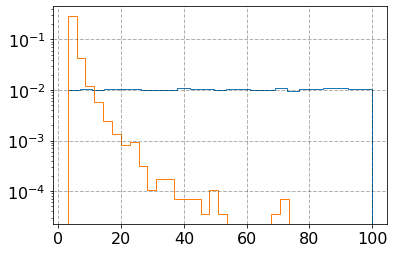

In [59]:
# plot prior distributions
plt.hist(old_prior.sample(10000)["mass_1"], bins=25, histtype="step", density=1)
plt.hist(new_prior.sample(10000)["mass_1"], bins=25, histtype="step", density=1)
plt.yscale("log")

In [41]:
reweighted_samples, weights = mass_1_prior_reweighting(
    samples_per_posterior, n_posteriors, original_samples,
    new_prior, old_prior)


In [46]:
old_samples = data["mass_1"][EVENT_IDX["GW170729"]]
new_samples = reweighted_samples["mass_1"][EVENT_IDX["GW170729"]]

(array([2.46635971e-03, 9.70631887e-03, 2.91189566e-02, 4.72586345e-02,
        5.06001541e-02, 4.76564345e-02, 5.19526740e-02, 4.72586345e-02,
        3.31765162e-02, 2.71299569e-02, 1.72645180e-02, 1.39229984e-02,
        8.03555907e-03, 6.04655930e-03, 2.62547970e-03, 1.90943978e-03,
        8.75159899e-04, 3.97799954e-04, 3.18239963e-04, 7.95599908e-05]),
 array([33.28769888, 35.80152522, 38.31535155, 40.82917789, 43.34300422,
        45.85683056, 48.37065689, 50.88448323, 53.39830956, 55.9121359 ,
        58.42596223, 60.93978856, 63.4536149 , 65.96744123, 68.48126757,
        70.9950939 , 73.50892024, 76.02274657, 78.53657291, 81.05039924,
        83.56422558]),
 <a list of 1 Patch objects>)

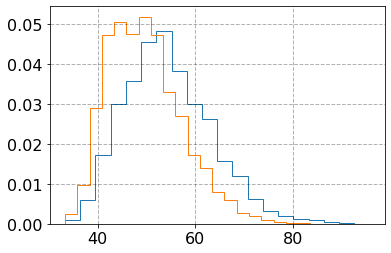

In [47]:
#plot posterior distributions
plt.hist(old_samples, bins=20, histtype="step", density=1)
plt.hist(new_samples, bins=20, histtype="step", density=1)